# Tensorflow Tokenizer 복습

In [1]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
sentences = ['nice great best amazing', 'stop lies', 'pitiful nerd', 'excellent word', 'supreme quality', 'bad', 'highly respectable']
y_train = [1, 0, 0, 1, 1, 0, 1]

In [3]:
t = Tokenizer()
t.fit_on_texts(sentences)         # 텍스트 -> 리스트
vocab_size = len(t.word_index) +1
print(vocab_size)

16


In [4]:
print(t.word_index)

{'nice': 1, 'great': 2, 'best': 3, 'amazing': 4, 'stop': 5, 'lies': 6, 'pitiful': 7, 'nerd': 8, 'excellent': 9, 'word': 10, 'supreme': 11, 'quality': 12, 'bad': 13, 'highly': 14, 'respectable': 15}


In [5]:
x_encoded = t.texts_to_sequences(sentences)    # 텍스트 -> 시퀀스
print(x_encoded)

[[1, 2, 3, 4], [5, 6], [7, 8], [9, 10], [11, 12], [13], [14, 15]]


In [6]:
# x_encoded의 최대값 구하기
max_len = max(len(l) for l in x_encoded)
print(max_len)

4


In [7]:
type(y_train)

list

In [8]:
x_train = pad_sequences(x_encoded, maxlen = 4, padding = 'post')
y_train = np.array(y_train)
print(type(y_train))
print(x_train)

<class 'numpy.ndarray'>
[[ 1  2  3  4]
 [ 5  6  0  0]
 [ 7  8  0  0]
 [ 9 10  0  0]
 [11 12  0  0]
 [13  0  0  0]
 [14 15  0  0]]


In [9]:
print(type(x_train))

<class 'numpy.ndarray'>


In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Flatten

youngwoo = Sequential()
youngwoo.add(Embedding(vocab_size, 2, input_length=max_len))
youngwoo.add(Flatten())
youngwoo.add(Dense(1, activation = 'sigmoid'))
youngwoo.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 4, 2)              32        
                                                                 
 flatten (Flatten)           (None, 8)                 0         
                                                                 
 dense (Dense)               (None, 1)                 9         
                                                                 
Total params: 41
Trainable params: 41
Non-trainable params: 0
_________________________________________________________________


In [11]:
youngwoo.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['acc'])
youngwoo.fit(x_train, y_train, epochs = 100, verbose = 1)

Epoch 1/100
1/1 [==============================] - 5s 5s/step - loss: 0.6751 - acc: 0.8571
Epoch 2/100
1/1 [==============================] - 0s 16ms/step - loss: 0.6739 - acc: 0.8571
Epoch 3/100
1/1 [==============================] - 0s 10ms/step - loss: 0.6727 - acc: 0.8571
Epoch 4/100
1/1 [==============================] - 0s 14ms/step - loss: 0.6715 - acc: 0.8571
Epoch 5/100
1/1 [==============================] - 0s 13ms/step - loss: 0.6703 - acc: 0.8571
Epoch 6/100
1/1 [==============================] - 0s 15ms/step - loss: 0.6691 - acc: 0.8571
Epoch 7/100
1/1 [==============================] - 0s 24ms/step - loss: 0.6679 - acc: 0.8571
Epoch 8/100
1/1 [==============================] - 0s 23ms/step - loss: 0.6666 - acc: 0.8571
Epoch 9/100
1/1 [==============================] - 0s 11ms/step - loss: 0.6654 - acc: 0.8571
Epoch 10/100
1/1 [==============================] - 0s 12ms/step - loss: 0.6642 - acc: 1.0000
Epoch 11/100
1/1 [==============================] - 0s 11ms/step - loss

# 네이버 영화리뷰 감성분석

In [12]:
import pandas as pd
import urllib.request
import matplotlib.pyplot as plt
import re
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter

In [13]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt") # train
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt") # test
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings.txt", filename="ratings.txt") # train + test

('ratings.txt', <http.client.HTTPMessage at 0x7ff1901e2e10>)

In [14]:
train_data = pd.read_table('ratings_train.txt')
test_data = pd.read_table('ratings_test.txt')

In [15]:
train_data.info

<bound method DataFrame.info of               id                                           document  label
0        9976970                                아 더빙.. 진짜 짜증나네요 목소리      0
1        3819312                  흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나      1
2       10265843                                  너무재밓었다그래서보는것을추천한다      0
3        9045019                      교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정      0
4        6483659  사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...      1
...          ...                                                ...    ...
149995   6222902                                인간이 문제지.. 소는 뭔죄인가..      0
149996   8549745                                      평점이 너무 낮아서...      1
149997   9311800                    이게 뭐요? 한국인은 거들먹거리고 필리핀 혼혈은 착하다?      0
149998   2376369                        청춘 영화의 최고봉.방황과 우울했던 날들의 자화상      1
149999   9619869                           한국 영화 최초로 수간하는 내용이 담긴 영화      0

[150000 rows x 3 columns]>

In [16]:
!pip install konlpy
!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git 
%cd Mecab-ko-for-Google-Colab/
!bash install_mecab-ko_on_colab190912.sh
%cd ../

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 19.4 MB 3.8 MB/s 
     |████████████████████████████████| 453 kB 63.5 MB/s 
Cloning into 'Mecab-ko-for-Google-Colab'...
remote: Enumerating objects: 115, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 115 (delta 11), reused 10 (delta 3), pack-reused 91
Receiving objects: 100% (115/115), 1.27 MiB | 25.51 MiB/s, done.
Resolving deltas: 100% (50/50), done.
/content/Mecab-ko-for-Google-Colab
Installing konlpy.....
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Done
Installing mecab-0.996-ko-0.9.2.tar.gz.....
from https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
--2022-05-24 04:03:10--  https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
Resolving bitbucket.org (bitbucket.org)... 104.

In [17]:
from konlpy.tag import Mecab
tokenizer = Mecab()

In [18]:
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [19]:
def tokenize_and_remove_stopwords(data, stopwords, tokenizer):
    result = []

    for sentence in data:
        curr_data = []
        curr_data = tokenizer.morphs(sentence) # mecab 형태소 분석 tokenizer
        curr_data = [word for word in curr_data if not word in stopwords] # 불용어 제거
        result.append(curr_data)
    return result

In [20]:
def load_data(train_data, test_data, num_words=10000):

    # 중복 제거
    train_data.drop_duplicates(subset=['document'], inplace=True)
    test_data.drop_duplicates(subset=['document'], inplace=True)

    # Nan 결측치 제거
    train_data = train_data.dropna(how='any')
    test_data = test_data.dropna(how='any')

    # 토큰화 및 불용어 제거
    x_train = tokenize_and_remove_stopwords(train_data['document'], stopwords, tokenizer)
    x_test = tokenize_and_remove_stopwords(test_data['document'], stopwords, tokenizer)

    # 단어장 만드는 중...
    words = np.concatenate(x_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}

    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
    
    x_train = list(map(wordlist_to_indexlist, x_train))
    x_test = list(map(wordlist_to_indexlist, x_test))

    return x_train, np.array(list(train_data['label'])), x_test, np.array(list(test_data['label'])), word_to_index

In [21]:
x_train, y_train, x_test, y_test, word_to_index = load_data(train_data, test_data)

In [22]:
print(x_train[10])

[2, 4, 39, 229, 6, 535]


In [23]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [24]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수
# 단, 모든 문장은 <BOS>로 시작하는 것을 말합니다.

def get_encoded_sentence(sentence, word_to_index): ##### 텍스트 -> 숫자
    return [word_to_index['<BOS>']] + [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해주는 함수입니다.
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. ##### 숫자 -> 텍스트
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])

# 여러개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다.
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [25]:
get_decoded_sentence(x_train[10], index_to_word)

'. 진짜 짱 다 ♥'

In [26]:
# 데이터 셋 내 문장 길이 분포
total_data_text = list(x_train) + list(x_test)

# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

# 문장 길이의 평균값, 최대값, 표준편차를 계산
print('문장길이 평균 :', np.mean(num_tokens))
print('문장길이 최대 :', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를 들면 최대길이를 (평균 + 2*표준편차)로 한다면,
max_tokens = np.mean(num_tokens) +2 * np.std(num_tokens)

maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens)/len(num_tokens)))

문장길이 평균 : 15.96938143432699
문장길이 최대 : 116
문장길이 표준편차 :  12.843571939469296
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [27]:
# 패딩 추가
x_train = pad_sequences(x_train, value=word_to_index['<PAD>'], padding='pre', maxlen=maxlen)
x_test = pad_sequences(x_test, value=word_to_index['<PAD>'], padding='pre', maxlen=maxlen)

In [28]:
print(x_train.shape)
print(x_test.shape)

(146182, 41)
(49157, 41)


In [29]:
vocab_size = 10000
word_vector_dim = 200 # 2의 배수

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.LSTM(8))
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 200)         2000000   
                                                                 
 lstm (LSTM)                 (None, 8)                 6688      
                                                                 
 dense_1 (Dense)             (None, 8)                 72        
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 2,006,769
Trainable params: 2,006,769
Non-trainable params: 0
_________________________________________________________________


In [30]:
x_val = x_train[:50000]
y_val = y_train[:50000]

partial_x_train = x_train[50000:]
partial_y_train = y_train[50000:]

In [31]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
epochs= 100
history = model.fit(partial_x_train, partial_y_train, epochs=epochs, batch_size=512, validation_data=(x_val, y_val), verbose=1)

Epoch 1/100
188/188 [==============================] - 7s 18ms/step - loss: 0.4730 - accuracy: 0.7910 - val_loss: 0.3659 - val_accuracy: 0.8445
Epoch 2/100
188/188 [==============================] - 3s 14ms/step - loss: 0.3341 - accuracy: 0.8621 - val_loss: 0.3465 - val_accuracy: 0.8509
Epoch 3/100
188/188 [==============================] - 3s 15ms/step - loss: 0.2983 - accuracy: 0.8789 - val_loss: 0.3442 - val_accuracy: 0.8524
Epoch 4/100
188/188 [==============================] - 3s 15ms/step - loss: 0.2711 - accuracy: 0.8910 - val_loss: 0.3499 - val_accuracy: 0.8514
Epoch 5/100
188/188 [==============================] - 3s 16ms/step - loss: 0.2465 - accuracy: 0.9022 - val_loss: 0.3582 - val_accuracy: 0.8525
Epoch 6/100
188/188 [==============================] - 3s 15ms/step - loss: 0.2237 - accuracy: 0.9126 - val_loss: 0.3722 - val_accuracy: 0.8509
Epoch 7/100
188/188 [==============================] - 3s 15ms/step - loss: 0.2042 - accuracy: 0.9215 - val_loss: 0.3877 - val_accuracy:

In [32]:
# 테스트 셋으로 평가
results = model.evaluate(x_test, y_test, verbose=2)
print(results)

1537/1537 - 4s - loss: 1.4099 - accuracy: 0.8148 - 4s/epoch - 2ms/step
[1.4099403619766235, 0.814777135848999]


In [33]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [34]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

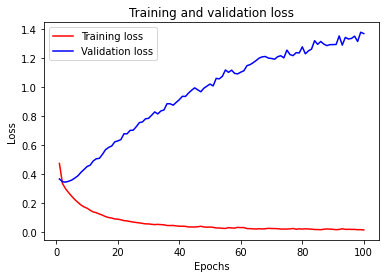

In [35]:
epochs = range(1, len(acc)+1)

plt.plot(epochs, loss, 'r-', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

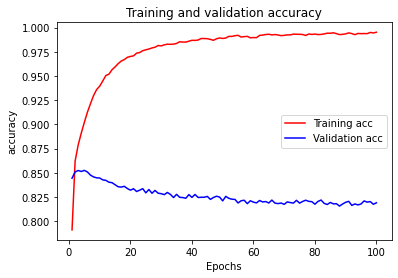

In [36]:
plt.clf() #그림을 초기화

plt.plot(epochs, acc, 'r-', label= 'Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

# 학습된 embedding layer 분석

In [37]:
# gensim의 유사단어 찾기를 활용하여 자체학습한 임베딩과 사전학습 임베딩을 적절히 분석함

# 학습한 Embedding 파라미터를 파일에 써서 저장합니다.
word2vec_file_path = './word2vec.txt'
f = open(word2vec_file_path,'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))
# 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.
# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 

vectors = model.get_weights()[0]
for i in range(4, vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [38]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['짜증']
vector

array([ 0.15580858, -0.28938973,  0.10739483,  0.12612085, -0.20633572,
       -0.12471739, -0.05660794, -0.22684155,  0.09004937, -0.12046291,
       -0.13774608,  0.04760656,  0.15057656, -0.25386196,  0.24156407,
        0.30689582,  0.05518514, -0.2210575 , -0.3859298 , -0.05182483,
       -0.22754383, -0.09216497,  0.08502796, -0.00778463,  0.15487154,
        0.09722812,  0.22758663,  0.34994432,  0.13683234,  0.0466015 ,
        0.30154076, -0.00866368,  0.15362553,  0.3626269 ,  0.12720175,
       -0.21770509,  0.20985614,  0.06503319,  0.0438489 ,  0.04731894,
       -0.32220814,  0.20307812,  0.4868101 , -0.20271619, -0.20187658,
       -0.2725406 ,  0.00617117,  0.11703383,  0.01430651,  0.10203454,
       -0.05263957, -0.02608506, -0.14276664,  0.01081853,  0.07490356,
       -0.20515321, -0.04361554, -0.16967162,  0.28818375,  0.08501735,
       -0.48535967,  0.0971254 , -0.24010472, -0.1800885 ,  0.08210629,
       -0.16673104, -0.04705849,  0.17278142,  0.06600767,  0.04

In [39]:
word_vectors.similar_by_word("재미")

[('순수', 0.7350402474403381),
 ('조재현', 0.6550747156143188),
 ('~~~~', 0.6433655023574829),
 ('마이클', 0.6331782341003418),
 ('아닐까', 0.6234041452407837),
 ('화보', 0.6225350499153137),
 ('고파', 0.6174125671386719),
 ('누구', 0.6162441968917847),
 ('제시', 0.6069259643554688),
 ('꾸준히', 0.5866397619247437)]

# 한국어 word2vec 임베딩 활용해 성능 개선

In [40]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [41]:
import gensim

word2vec_path = '/content/drive/MyDrive/dataset/ko.bin'
word2vec = gensim.models.Word2Vec.load(word2vec_path)
vector = word2vec['감동']
vector

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """


array([-1.4411083 , -0.78142536,  2.453768  , -0.86445606,  0.24195324,
        0.36006922, -1.0639709 ,  0.85037315, -1.0184479 ,  0.21196692,
       -0.6679936 ,  0.6389819 , -0.26964295,  0.66028535,  0.39613017,
        0.6428288 ,  0.6648245 ,  0.08363932, -0.2540794 ,  0.55310047,
        0.63392764,  0.19311981, -0.4648248 ,  0.1490374 ,  2.0762694 ,
        0.7872764 , -0.21711552, -0.59049505, -1.3264338 , -0.06233318,
        1.2550159 , -0.05334642, -0.5453753 , -0.8736315 ,  0.5253877 ,
        0.03122815,  0.8280226 ,  0.23597455,  0.06136359,  1.5114233 ,
       -0.340495  ,  0.912277  ,  0.5899006 , -1.3025732 , -0.87596595,
        0.21738248,  1.0366931 , -0.55709684, -0.9039502 ,  0.28133616,
       -1.7572548 , -0.29769212, -0.14536098,  0.5850025 , -0.6111547 ,
       -0.29829553,  1.4106004 , -0.38685524,  0.4801454 ,  0.40166005,
        0.28174093,  1.6133646 , -0.8590998 ,  0.49886975,  0.38605362,
       -0.1607663 , -0.87983316,  0.21996935,  0.68561727, -0.84

In [42]:
word2vec.similar_by_word('로맨틱')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  """Entry point for launching an IPython kernel.


[('코미디', 0.7576364278793335),
 ('로맨스', 0.7021660804748535),
 ('스릴러', 0.6693054437637329),
 ('개그', 0.6552960872650146),
 ('주제곡', 0.6495761871337891),
 ('뮤지컬', 0.6382305026054382),
 ('시트콤', 0.6167846322059631),
 ('서부극', 0.6151247620582581),
 ('연극과', 0.6083630323410034),
 ('서정적', 0.5965933799743652)]

In [43]:
vocab_size = 10000   # 어휘 사전의 크기
word_vector_dim = 200

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드벡터를 단어 하나씩마다 차례차례 카피한다
for i in range(4, vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


In [44]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000
word_vector_dim = 200

model = Sequential()
model.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer = Constant(embedding_matrix), # 카피한 임베딩을 여기서 활용
                                 input_length = maxlen,
                                 trainable = True)) # trainable을 True로 주면 Fine-tuning
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.MaxPooling1D(5))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 41, 200)           2000000   
                                                                 
 conv1d (Conv1D)             (None, 35, 16)            22416     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 7, 16)            0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 1, 16)             1808      
                                                                 
 global_max_pooling1d (Globa  (None, 16)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_3 (Dense)             (None, 8)                

In [45]:
# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

epochs = 20

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
188/188 [==============================] - 9s 11ms/step - loss: 0.6178 - accuracy: 0.6403 - val_loss: 0.4930 - val_accuracy: 0.7651
Epoch 2/20
188/188 [==============================] - 2s 8ms/step - loss: 0.4325 - accuracy: 0.8000 - val_loss: 0.3966 - val_accuracy: 0.8223
Epoch 3/20
188/188 [==============================] - 2s 9ms/step - loss: 0.3553 - accuracy: 0.8458 - val_loss: 0.3700 - val_accuracy: 0.8373
Epoch 4/20
188/188 [==============================] - 2s 8ms/step - loss: 0.3107 - accuracy: 0.8688 - val_loss: 0.3675 - val_accuracy: 0.8413
Epoch 5/20
188/188 [==============================] - 2s 8ms/step - loss: 0.2793 - accuracy: 0.8855 - val_loss: 0.3664 - val_accuracy: 0.8445
Epoch 6/20
188/188 [==============================] - 2s 9ms/step - loss: 0.2508 - accuracy: 0.9001 - val_loss: 0.3783 - val_accuracy: 0.8424
Epoch 7/20
188/188 [==============================] - 2s 9ms/step - loss: 0.2273 - accuracy: 0.9123 - val_loss: 0.3896 - val_accuracy: 0.8405
Epoch

In [46]:
result = model.evaluate(x_test, y_test, verbose = 2)
print(result)

1537/1537 - 3s - loss: 0.8326 - accuracy: 0.8224 - 3s/epoch - 2ms/step
[0.8325678706169128, 0.8223650455474854]
